# ТЗ

Нужно создать бейзлайн модели для классификации текстов по функционально-смысловым типам речи. Три класса - повествование, описание, рассуждение. 

Подход почти что rule-based в силу отсутствия готового датасета и времени. В перспективе - собрать датасет, обучить нейронку и создать для всего этого дела интерфейс (веб или тг-бот).

**Повествование**

Повествование как тип речи — это сообщение о действиях предмета в определенной последовательности.

Композиционная структура повествования:

* завязка (начало действия);
* развитие действия;
* кульминация (самый острый, интересный момент);
* развязка (конец действия)

Средства языкового оформления повествования:

* преобладают глаголы и глагольные формы;
* глаголы в форме прошедшего времени совершенного вида;
* простые и составные глагольные сказуемые;
* обстоятельства времени.



**Описание**

Описание как тип речи — это сообщение об одновременных признаках предмета.

Композиционная структура описания:

* общее впечатление от предмета речи;
* признаки предмета речи;
* авторская оценка описываемого.
Особенности языкового оформления описания

В описании автор использует следующие языковые средства:

* преобладают имена существительные и прилагательные;
* глаголы в  форме настоящего времени несовершенного вида;
* составные именные сказуемые;
* обстоятельства места.


**Рассуждение**

Рассуждение — тип речи, в котором исследуются предметы или явления, раскрываются их внутренние признаки. Рассуждением может стать словесное изложение, разъяснение и подтверждение какой-то мысли. Рассуждая, говорящий объясняет что-то, доказывает или опровергает с помощью аргументов свою точку зрения на предмет или явление действительности.

Композиционная структура рассуждения:

* тезис (основная мысль);
* аргументы (доказательства или опровержение);
* вывод.

Языковые средства рассуждения:

* преобладает абстрактная лексика;
* имеются вводные слова;
* используются обстоятельства цели, причины, следствия, уступки;
* сложноподчиненные предложения с придаточными причины, цели, следствия, уступки.


Источники:

https://russkiiyazyk.ru/sintaksis/tipy-rechi.html

https://srcaltufevo.ru/tip-rechi-v-kotorom-tip-rechi-opisanie-povestvovanie-rassuzhdenie-tip.html 

# Парсинг решуегэ

В ЕГЭ по русскому языку присутствует задание на ФСТР (функционально-смысловые типы речи). Задание относится к тестовым и в 2022 году фигурирует под номером 23. В нем требуется прочитать текст с пронумерованными предложениями и ответить на 5 вопросов (либо отметить верные, либо отметить ошибочные утверждения). 

Среди вопросов встречаются вопросы типа "В предложениях 3—7 представлено рассуждение". Именно подобный тип парсится для данной задачи.

Сайт: https://rus-ege.sdamgia.ru/

In [ ]:
def invert(num: str, total: int=5):
    """Если в условии присутствует "найти ошибочные пункты",
    то нужно инвертировать ответ"""
    output = ''
    for n in range(1, total+1):
        if not str(n) in num:
            output += str(n)
    return output


def correct_questions(questions: tp.List[str], answers_num: str, total: int=5):
    """Выделение из общего списка вопросов, на которые дан 
    положительный ответ"""
    correct = []
    for num in answers_num:
        num = int(num)
        if num < total:
            correct.append(re.search(f"{num}\)(.*){num+1}\)", questions)[1].lower())
        else:
            correct.append(re.search(f"{num}\)(.*)", questions)[1].lower())
    return correct


def get_sentence_numbers(sentence: str):
    """Выделение из ответов интервалов/отдельных предложений как чисел"""
    lst = set()
    intervals = re.findall(r'\d+–\d+', sentence)
    for interval in intervals:
        start, end = interval.split('–')
        for i in range(int(start), int(end)+1):
            lst.add(i)
    alone = re.findall(r'\d+', sentence)
    for al in alone:
        lst.add(int(al))
    return sorted(list(lst))


def get_sentence(sent_num: int, text: str):
    """Выделение из общего текста предложений под определенными номерами"""
    try:
        sentence = re.search(f"\({sent_num}\)(.*)\({sent_num+1}\)", text)[1]
    except TypeError:
        sentence = re.search(f"\({sent_num}\)(.*)\(\D", text)[1]
    return sentence

In [ ]:
website = 'https://rus-ege.sdamgia.ru'
problem_links = []

for theme in [230, 313, 283]:  # все доступные 23-и задания на поиск ФСТР
    page = requests.get(website + f'/test?theme={theme}&print=true')
    soup = BeautifulSoup(page.text, 'html.parser')
    for found in soup.findAll('span', {'class': 'prob_nums'}):
        problem_links.append(found.a['href'])

In [ ]:
pov = []
op = []
ras = []

for problem_link in problem_links:

    try: # несмотря на то, что задания максимально унифицированы, иногда бывают приколы
        task_link = website + problem_link
        task_page = requests.get(task_link)
        task_soup = BeautifulSoup(task_page.text, 'html.parser')

        id = re.search(r'problem\?id=(.*)', task_link)[1]

        questions = task_soup.find('div', {'align': 'justify', 'class': 'pbody'}).text
        questions = questions.replace('\u202f', '').replace('\xa0', '')

        paragraphs = task_soup.findAll('div', {'id': f'text{id}'})[0]
        text = paragraphs.text
        text = text.replace('\u202f', '').replace('\xa0', '')

        answers = task_soup.findAll('div', {'id': f'sol{id}'})[0].text
        answers_num = re.search(r'Ответ:(.*)', answers)[1].split('|')[0]
        answers_num = ''.join(list(filter(lambda s: s.isdigit(), answers_num)))

        init_question = questions.split('?')[0].lower()
        if 'неверными' in init_question or 'ошибочными' in init_question or ' не ' in init_question:
            answers_num = invert(answers_num)

        questions_with_yes = correct_questions(questions, answers_num)

        for question in questions_with_yes:
            for item in ['не ', 'нет', 'неверно', 'неправильно', 'некорректно', 'ошибочно', 'элементами']:
                if question.find(item) != -1:
                    break
            else:
                sentence_numbers = get_sentence_numbers(question)
                new_text = []
                for sent_num in sentence_numbers:
                    new_text.append(get_sentence(sent_num, text).strip())
                new_text = ' '.join(new_text)

                if question.find('повествование') != -1:
                    pov.append(new_text)
                elif question.find('описание') != -1:
                    op.append(new_text)
                elif question.find('рассуждение') != -1:
                    ras.append(new_text)

    except TypeError:
        continue

In [ ]:
# запись полученных данных в файл

with open('ege23task.txt', 'w') as file:
    file.write('ПОВЕСТВОВАНИЕ\n\n')
    file.write('\n\n'.join(pov))
    file.write('\n\nОПИСАНИЕ\n\n')
    file.write('\n\n'.join(op))
    file.write('\n\nРАССУЖДЕНИЕ\n\n')
    file.write('\n\n'.join(ras))

# Основной код

In [1]:
# установка библиотек

%%capture
! pip install razdel navec pymystem3==0.1.10 # по какой-то странной причине яндесовский лемматизатор других версий не совместим с колабом 

In [2]:
# импорты

import pickle
import typing as tp
import json
from pymystem3 import Mystem
from razdel import sentenize
from navec import Navec
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from bs4 import BeautifulSoup
import requests

sns.set()

In [21]:
# подклучение гугл-диска

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# загрузка предобученого word2vec-а

%%capture
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [23]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [24]:
# вспомогательные функции

def remove_empty_sents(text: tp.List[str]) -> tp.List[str]:
    """Удаление пустых строк из списка, содержащего строки,
    а также лишних пробелов в начале и конце строк"""
    fltr = filter(lambda t: len(t) != 0, text)
    mp = map(lambda t: t.strip(), list(fltr))
    return list(mp)


def sentence_tokenize(text: str) -> tp.List[str]:
    """Разделение исходного текста на отдельные предложения"""
    output = []
    for item in list(sentenize(text)):
        output.append(item.text)
    return output


def report(test, pred):  
    """Визуализация матрицы ошибок и вывод основных метрик. 
    Строки - истинные значения, столбцы - предсказанные"""
    print(classification_report(test, pred))
    cm = confusion_matrix(test, pred)
    df_cm = pd.DataFrame(cm, index=["ОПИСАНИЕ", "ПОВЕСТВОВАНИЕ", "РАССУЖДЕНИЕ"],
                         columns=["ОПИСАНИЕ", "ПОВЕСТВОВАНИЕ", "РАССУЖДЕНИЕ"])
    plt.figure(figsize = (7, 5))
    plt.title("Confusion matrix")
    ax = sns.heatmap(df_cm, annot=True, cmap="Greens", fmt='g')
    plt.show()

**Струкура файла с данными**. Тексты разделены двумя enter-ами.

ПОВЕСТВОВАНИЕ

...тексты...

ОПИСАНИЕ

...тексты...

РАССУЖДЕНИЕ

...тексты...

In [25]:
# чтение данных

with open('/content/drive/MyDrive/Вузовское/CompLing/ege23task.txt') as file:
    content = file.read()

In [26]:
breakpoints = [content.find('ПОВЕСТВОВАНИЕ'), content.find('ОПИСАНИЕ'), content.find('РАССУЖДЕНИЕ')]

In [27]:
type_texts = {'ПОВЕСТВОВАНИЕ': remove_empty_sents(content[breakpoints[0] + len('ПОВЕСТВОВАНИЕ'):breakpoints[1]].split('\n\n')), 
              'ОПИСАНИЕ': remove_empty_sents(content[breakpoints[1] + len('ОПИСАНИЕ'):breakpoints[2]].split('\n\n')), 
              'РАССУЖДЕНИЕ': remove_empty_sents(content[breakpoints[2] + len('РАССУЖДЕНИЕ'):].split('\n\n'))}

Каждый текст преобразуется в вектор. Вектор состоит из двух частей - "статистического вектора" и "смыслового вектора". 

Статистический вектор усредняется путем деления на свою длину и содержит в себе информацию о:
* количестве различных частей речи. Для глаголов также указывается их время (если определено), а для союзов - тип
* количество редких слов
* количество вводных слов
* количество различных знаков препенания, использующихся в качестве окончания предложений

Смысловой вектор содержит в себе сумму значений из предобученного word2vec (navec на 500К слов из проекта natasha) по всем словам, которые несут смысловую информацию, т.е. знаки препинания сюда не входят. Вектор усредняется путем деления на кол-во слагаемых, составляющих его.

In [28]:
# https://yandex.ru/dev/mystem/doc/grammemes-values.html

possible_tags = ['ADVPRO',	# местоименное наречие
                 'ANUM',	# числительное-прилагательное
                 'APRO',	# местоимение-прилагательное
                 'ADV', # наречие
                 'PART', #	частица
                 'A',	# прилагательное
                 'SPRO',	# местоимение-существительное
                 'CONJ',	# союз
                 'INTJ', # междометие
                 'COM',	# часть композита - сложного слова
                 'NUM',	# числительное
                 'PR', #	предлог
                  'S', # существительное
                  'V'] # глагол

verb_time = ['наст', # настоящее
             'непрош',	# будущее
             'прош']	# прошедшее
             
rare = 'редк'
parenth = 'вводн'

# список далеко не полный, но хоть что-то
s_conjs = ['и', 'да', 'a', 'но', 'тоже', 'также', 'или', 'либо', 'зато', 'однако'] 
p_conjs = ['что', 'чтобы', 'как', 'когда', 'ибо', 'пока', 'будто', 'словно', 
           'если', 'кто', 'который', 'какой', 'где', 'куда', 'откуда']

punct = ['.', '!', '?', '...', '?..', '!..']

colnames = {el:i for i, el in enumerate(['ADVPRO', 'ANUM', 'APRO', 'ADV', 'PART', 
                                           'A', 'SPRO', 'CONJ_S', 'CONJ_P', 'INTJ', 
                                         'COM', 'NUM', 'PR', 'S', 'V', 'V_наст', 'V_непрош', 
                                         'V_прош', 'редк', 'вводн', '.', '!', '?', 
                                         '...', '?..', '!..'])}

In [29]:
mystem = Mystem()
    
def text2vec(text: str='', return_lemmatized: bool=False):
    """Переводит текст (предложение) в вектор. Использует в
    работе глобальные переменные из предыдущей ячейки"""

    analysis = mystem.analyze(text)
    stats_vec = np.zeros(len(colnames))
    word2vec_vec = np.zeros(300)
    n_word2vec = 0
    norm_text = []

    for item in analysis:
        word = item['text'].lower()
        try:
            analysis = item['analysis'][0]
        except KeyError:
            analysis = None

        if analysis is not None:
            word2vec_vec += navec[word] if word in navec else navec['<unk>']
            n_word2vec += 1

            norm_form = analysis['lex']  # нормальная форма
            norm_text.append(norm_form)
            grammar = analysis['gr']  # морфология
            for tos in possible_tags:
                if grammar.find(rare) != -1:
                    stats_vec[colnames[rare]] += 1
                if grammar.find(parenth) != -1:
                    stats_vec[colnames[parenth]] += 1
                if grammar.find(tos) != -1:
                    if tos == 'V':
                        for tm in verb_time:
                            if grammar.find(tm) != -1:
                                stats_vec[colnames[f'V_{tm}']] += 1
                                break
                        else:
                            stats_vec[colnames[tos]] += 1
                    elif tos == 'CONJ':
                        if item['text'].lower() in s_conjs:
                            stats_vec[colnames['CONJ_S']] += 1
                        else: 
                            stats_vec[colnames['CONJ_P']] += 1
                    else:
                        stats_vec[colnames[tos]] += 1
                    break

    stats_vec /= len(stats_vec)  # нормализация векторов
    word2vec_vec = word2vec_vec / n_word2vec if n_word2vec != 0 else word2vec_vec

    vec = np.hstack((stats_vec, word2vec_vec))  # объединение "статистического" и "смыслового" векторов

    if return_lemmatized:
        return vec, ' '.join(norm_text)
    return vec

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [30]:
text_types = []
sentences = []
for key, texts in type_texts.items():
    for text in texts:
        # new_ones = sentence_tokenize(text) - это, если мы хотим обучаться только на предложениях, а не текстах
        new_ones = [text]
        sentences.extend(new_ones)
        text_types.extend([key] * len(new_ones))

data = pd.DataFrame({'text': sentences, 'text_type': text_types})
data['vector'] = data['text'].apply(text2vec)
data.head()

,text,text_type,vector
0,В 1902 году царское правительство аннулировало...,ПОВЕСТВОВАНИЕ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.07692307692307693,..."
1,"...Прошло много лет. И вдруг в доме, расположе...",ПОВЕСТВОВАНИЕ,"[0.0, 0.0, 0.0, 0.07692307692307693, 0.0, 0.0,..."
2,"Давно прозвучали эти слова, и вот недавно в од...",ПОВЕСТВОВАНИЕ,"[0.0, 0.0, 0.07692307692307693, 0.076923076923..."
3,"Я погладил его пушистую головку, и малыш довер...",ПОВЕСТВОВАНИЕ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.11538461538461539,..."
4,"Он уже слышал, что Маршак еле жив, что врачи б...",ПОВЕСТВОВАНИЕ,"[0.0, 0.0, 0.038461538461538464, 0.07692307692..."


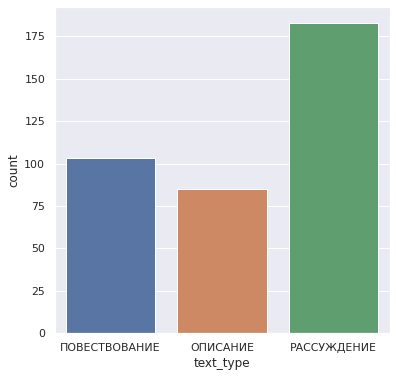

In [31]:
# количество текстов по классам

fig = plt.figure(figsize=(6, 6))
sns.countplot(data=data, x='text_type')

In [33]:
# разбиение данных на train-test

x_train, x_test, y_train, y_test = train_test_split(data.vector, data.text_type, train_size=0.8, random_state=42)
x_train, x_test = list(x_train), list(x_test)

               precision    recall  f1-score   support

     ОПИСАНИЕ       0.92      0.86      0.89        14
ПОВЕСТВОВАНИЕ       0.96      0.93      0.94        27
  РАССУЖДЕНИЕ       0.89      0.94      0.91        34

     accuracy                           0.92        75
    macro avg       0.92      0.91      0.92        75
 weighted avg       0.92      0.92      0.92        75



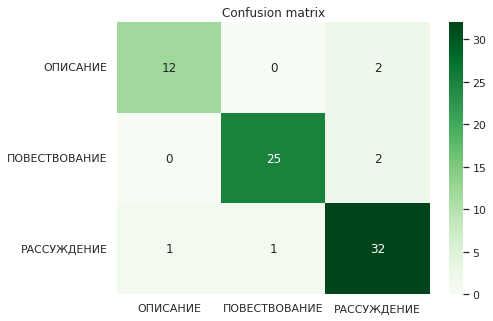

In [34]:
# логистическая регрессия 

clf = LogisticRegression(tol=10**-6, max_iter=10000, C=1e5, multi_class='ovr')  
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
report(y_test, y_pred)

               precision    recall  f1-score   support

     ОПИСАНИЕ       0.75      0.86      0.80        14
ПОВЕСТВОВАНИЕ       0.92      0.89      0.91        27
  РАССУЖДЕНИЕ       0.94      0.91      0.93        34

     accuracy                           0.89        75
    macro avg       0.87      0.89      0.88        75
 weighted avg       0.90      0.89      0.89        75



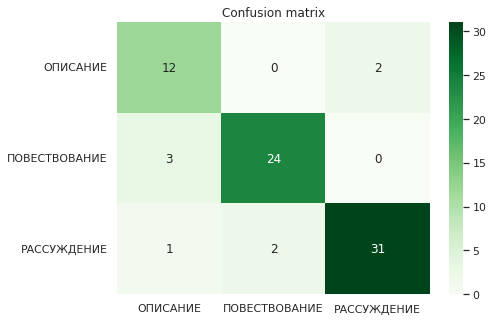

In [35]:
# метод опорных векторов

clf = SVC(tol=10**-6, kernel='linear', C=1e5, probability=True) 
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
report(y_test, y_pred)

# Итог

In [43]:
# лучший классификатор, который получился на текущий момент

model = LogisticRegression(tol=10**-6, max_iter=10000, C=1e5, multi_class='ovr')  
model.fit(x_train, y_train)
pickle.dump(model, open('best_model', 'wb'))

In [44]:
clf = pickle.load(open('best_model', 'rb'))

In [50]:
def get_pred(clf, text: str=''):
    """Относитель удобный интерфейс для вывода 
    предсказанного класса и его вероятности"""
    inner = [text2vec(text)]
    classes = clf.classes_
    probs = clf.predict_proba(inner)[0]
    pred = classes[np.argmax(probs)]

    pie, ax = plt.subplots(figsize=[10, 6])
    x = list(map(lambda t: t.capitalize(), classes))
    colors = ['#FFC09F','#D3DFB8','#C3ACCE']
    percent = 100.*probs
    patches, texts = plt.pie(probs, colors=colors, startangle=90, radius=1.2)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]
    plt.legend(patches, labels, loc='best', fontsize=14)
    plt.title("Вероятности типов речи", fontsize=16, fontweight='bold')
    # plt.savefig('pie.png')

    return pred.capitalize(), pie

('Повествование', <Figure size 720x432 with 1 Axes>)

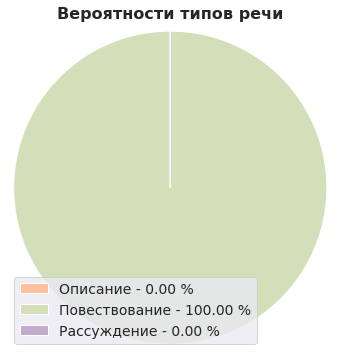

In [51]:
get_pred(clf, 'Я пришла забрать свою чашку.')

('Описание', <Figure size 720x432 with 1 Axes>)

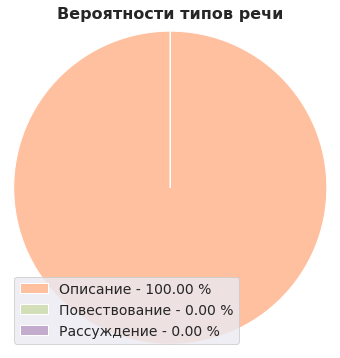

In [52]:
get_pred(clf, 'Деревья стояли голые и печальные.')

('Рассуждение', <Figure size 720x432 with 1 Axes>)

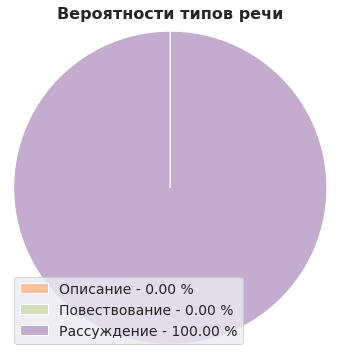

In [53]:
get_pred(clf, 'Наверное, всё было не зря?')

('Описание', <Figure size 720x432 with 1 Axes>)

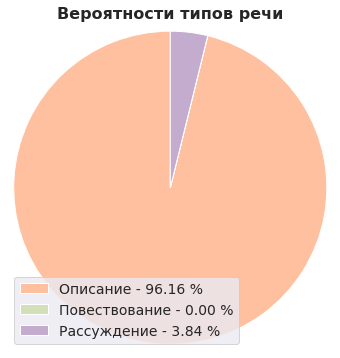

In [54]:
get_pred(clf, """Лицо старой, дореволюционной России определялось, например, в большой степени теми сотнями тысяч церквей и колоколен, 
которые были расставлены по всем её просторам на возвышенных преимущественно местах и которые определяли силуэт каждого города — 
от самого большого до самого маленького, а также сотнями монастырей, бесчисленным количеством ветряных и водяных мельниц.""")